# Episode 2: The [Table] Clone Wars

This notebook demonstrates the full entity extraction process on transistor data sheets, extracting min/max storage temperatures.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from snorkel.parser import HTMLParser
html_parser = HTMLParser(path='data/hardware_docs/')

In [2]:
from snorkel.parser import TableParser
table_parser = TableParser()

In [30]:
from snorkel.parser import Corpus
%time corpus = Corpus(html_parser, table_parser, max_docs=20)

Parsing documents...
Parsing contexts...
Parsed 20 documents and 156 contexts
CPU times: user 13 s, sys: 726 ms, total: 13.7 s
Wall time: 21.6 s


In [31]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
table_ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-80,high=-40)
# number_matcher = NumberMatcher()

In [32]:
from snorkel.candidates import Candidates
%time candidates = Candidates(table_ngrams, number_matcher, corpus.get_contexts())
for c in candidates.get_candidates()[:10]: print c

Extracting candidates...
CPU times: user 1.31 s, sys: 59 ms, total: 1.37 s
Wall time: 1.33 s
<TableNgram("-55", id=17-0-38-0:0-2, chars=[0,2], (row,col)=(9,2), tag=td)
<TableNgram("-65", id=19-1-43-0:0-2, chars=[0,2], (row,col)=(12,2), tag=td)
<TableNgram("-40", id=7-1-10-0:0-2, chars=[0,2], (row,col)=(2,2), tag=td)
<TableNgram("-50", id=7-3-35-0:0-2, chars=[0,2], (row,col)=(6,4), tag=td)
<TableNgram("-50", id=12-1-33-0:0-2, chars=[0,2], (row,col)=(4,5), tag=td)
<TableNgram("-55", id=9-0-22-0:0-2, chars=[0,2], (row,col)=(5,2), tag=td)
<TableNgram("-50", id=7-3-29-0:0-2, chars=[0,2], (row,col)=(5,4), tag=td)
<TableNgram("-50", id=12-1-44-0:3-5, chars=[3,5], (row,col)=(6,2), tag=td)
<TableNgram("-65", id=21-0-46-0:0-2, chars=[0,2], (row,col)=(14,2), tag=td)
<TableNgram("-65", id=22-1-43-0:0-2, chars=[0,2], (row,col)=(12,2), tag=td)


In [33]:
# from snorkel.snorkel import Entities
# from snorkel.matchers import CandidateExtractor
# tables = corpus.get_contexts()
# CE = CandidateExtractor(table_ngrams, number_matcher)
# E = Entities(tables, CE)

In [34]:
from snorkel.features import TableNgramFeaturizer

featurizer = TableNgramFeaturizer(candidates, corpus)

Extracting features...
Extracted 679 features for each of 26 mentions


In [35]:
featurizer.get_features_by_id(candidates.get_candidates()[2].id)[:10]

[u'BASIC_NGRAM_-40',
 'TABLE_ROW_NUM_2',
 'TABLE_COL_NUM_2',
 'TABLE_HTML_TAG_td',
 'TABLE_HTML_ATTR_style=width:108pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt',
 'TABLE_HTML_ANC_TAG_tr',
 'TABLE_HTML_ANC_TAG_table',
 'TABLE_HTML_ANC_TAG_body',
 'TABLE_HTML_ANC_ATTR_style=height:16pt',
 'TABLE_HTML_ANC_ATTR_style=border-collapse:collapse;margin-left:23.7102pt']

We now build a legacy DDLiteModel with which we will do the learning stages.

In [36]:
import cPickle
pkl_f = 'data/hardware_gold_train.pkl'
with open(pkl_f, 'rb') as f:
    gt_dict = cPickle.load(f)
    
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates.get_candidates(), featurizer.get_features(), gt_dict=gt_dict)    

In [44]:
c = candidates.get_candidates()[2]
print c

<TableNgram("-40", id=7-1-10-0:0-2, chars=[0,2], (row,col)=(2,2), tag=td)


In [45]:
# NOTE: make sure that these are made case insensitive
def LF_to(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'Storage' in m.aligned('words') else 0
def LF_tstg(m):
    return 1 if 'Tstg' in m.aligned('words') else 0
def LF_temperature(m):
    return 1 if 'Temperature' in m.aligned('words') else 0

def LF_n(m):
    return -1 if m.n > 1 else 0

In [46]:
LFs = [LF_to, LF_storage, LF_tstg, LF_temperature, LF_n]
DDL.apply_lfs(LFs, clear=False)
for lf in LFs:
    print lf(c)

0
0
0
0
0


In [47]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	42.308%
Overlap:	42.308%
Conflict:	0.000%


In [41]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.884019
	Learning epoch = 250	Gradient mag. = 2.108481
Final gradient magnitude for rate=0.01, mu=1e-07: 1.713
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.731533
	Learning epoch = 250	Gradient mag. = 0.746927
	Learning epoch = 500	Gradient mag. = 0.724804
	Learning epoch = 750	Gradient mag. = 0.703627
	Learning epoch = 1000	Gradient mag. = 0.683352
	Learning epoch = 1250	Gradient mag. = 0.663936
	Learning epoch = 1500	Gradient mag. = 0.645339
	Learning epoch = 1750	Gradient mag. = 0.627523
	Learning epoch = 2000	Gradient mag. = 0.610449
	Learning epoch = 2250	Gradient mag. = 0.594083
	Learning epoch = 2500	Gradient mag. = 0.578392
	Learning epoch = 2750	Gradient mag. = 0.563344
Final gradient magnitude for rate=0.01, mu=1e-09: 0.549
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.731533
	Learning epoch = 250	Gradient mag. = 0

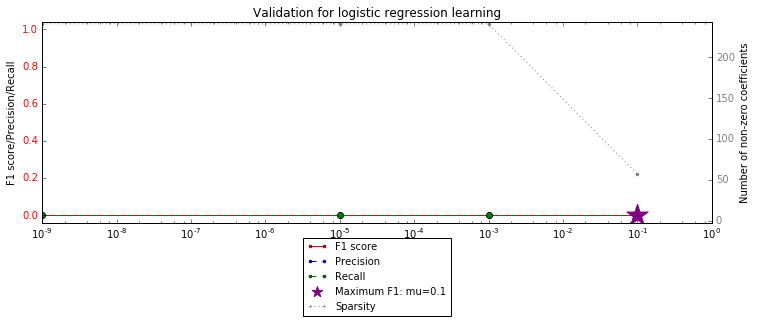

CPU times: user 3.46 s, sys: 67.2 ms, total: 3.53 s
Wall time: 3.6 s


<snorkel.snorkel.ModelLog instance at 0x115e47fc8>

In [42]:
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)